In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mhkit import wave
import pandas as pd


In [41]:

data_type = '3-hour'
year = [2010]
parameters = [
    'omni-directional_wave_power',
    'significant_wave_height',
    'energy_period',
    'directionality_coefficient',
    'maximum_energy_direction',
    'mean_absolute_period',
    'mean_zero-crossing_period',
    'peak_period',
    'spectral_width'
]
lat_lon = (43.5, -70) # off coast of Maine
data, metadata = wave.io.hindcast.hindcast.request_wpto_point_data(data_type, parameters, lat_lon, year)
data.head()

,omni-directional_wave_power_0,significant_wave_height_0,energy_period_0,directionality_coefficient_0,maximum_energy_direction_0,mean_absolute_period_0,mean_zero-crossing_period_0,peak_period_0,spectral_width_0
time_index,,,,,,,,,
2010-01-01 00:00:00+00:00,1250.461548,0.59368,4.0172,0.898,172.5,4.9468,7.1971,10.9619,0.5247
2010-01-01 03:00:00+00:00,1488.557739,0.61967,4.1974,0.792,142.5,5.2501,7.7880,12.0135,0.5248
2010-01-01 06:00:00+00:00,1397.676758,0.60245,4.2983,0.797,127.5,5.3097,7.7302,12.0135,0.5230
2010-01-01 09:00:00+00:00,1351.827881,0.59589,4.3503,0.807,127.5,5.3221,7.6388,12.0135,0.5241
2010-01-01 12:00:00+00:00,1342.985474,0.59008,4.4666,0.825,127.5,5.4596,7.7342,12.0135,0.5120


In [91]:
data_mod = data

rho_w = 1025  # kg/m^3, density of water
g = 9.81  # m/s^2, acceleration due to gravity
#J_calc = data_mod["significant_wave_height_0"]**2 * rho_w * g**2 / (64 * np.pi) * data_mod["energy_period_0"]
J_calc = data_mod["significant_wave_height_0"]**2 * rho_w * g**2 / (64 * np.pi) * data_mod["mean_zero-crossing_period_0"]
fudge = 1 - .007 * (data_mod["mean_zero-crossing_period_0"] - (2*np.pi)) 
data_mod["Power_density_predicted"] = J_calc / fudge #/ data_mod["spectral_width_0"] #* data_mod["directionality_coefficient_0"]
data_mod["ratio_power_density"] = data_mod["omni-directional_wave_power_0"] / data_mod["Power_density_predicted"]

data_mod.head()


,omni-directional_wave_power_0,significant_wave_height_0,energy_period_0,directionality_coefficient_0,maximum_energy_direction_0,mean_absolute_period_0,mean_zero-crossing_period_0,peak_period_0,spectral_width_0,Power_density_predicted,...,Avail_limited_90,Avail_limited_100,Avail_limited_200,Avail_limited_300,Avail_limited_400,Avail_limited_500,Avail_limited_600,Avail_limited_700,Avail_limited_800,Avail_limited_900
time_index,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,1250.461548,0.59368,4.0172,0.898,172.5,4.9468,7.1971,10.9619,0.5247,1252.511475,...,0.064856,0.058370,0.029185,0.019457,0.014593,0.011674,0.009728,0.008339,0.007296,0.006486
2010-01-01 03:00:00+00:00,1488.557739,0.61967,4.1974,0.792,142.5,5.2501,7.7880,12.0135,0.5248,1482.783813,...,0.077205,0.069484,0.034742,0.023161,0.017371,0.013897,0.011581,0.009926,0.008686,0.007720
2010-01-01 06:00:00+00:00,1397.676758,0.60245,4.2983,0.797,127.5,5.3097,7.7302,12.0135,0.5230,1390.548584,...,0.072491,0.065242,0.032621,0.021747,0.016311,0.013048,0.010874,0.009320,0.008155,0.007249
2010-01-01 09:00:00+00:00,1351.827881,0.59589,4.3503,0.807,127.5,5.3221,7.6388,12.0135,0.5241,1343.476685,...,0.070113,0.063102,0.031551,0.021034,0.015775,0.012620,0.010517,0.009015,0.007888,0.007011
2010-01-01 12:00:00+00:00,1342.985474,0.59008,4.4666,0.825,127.5,5.4596,7.7342,12.0135,0.5120,1334.759277,...,0.069655,0.062689,0.031345,0.020896,0.015672,0.012538,0.010448,0.008956,0.007836,0.006965


Text(0, 0.5, 'J calc / J ')

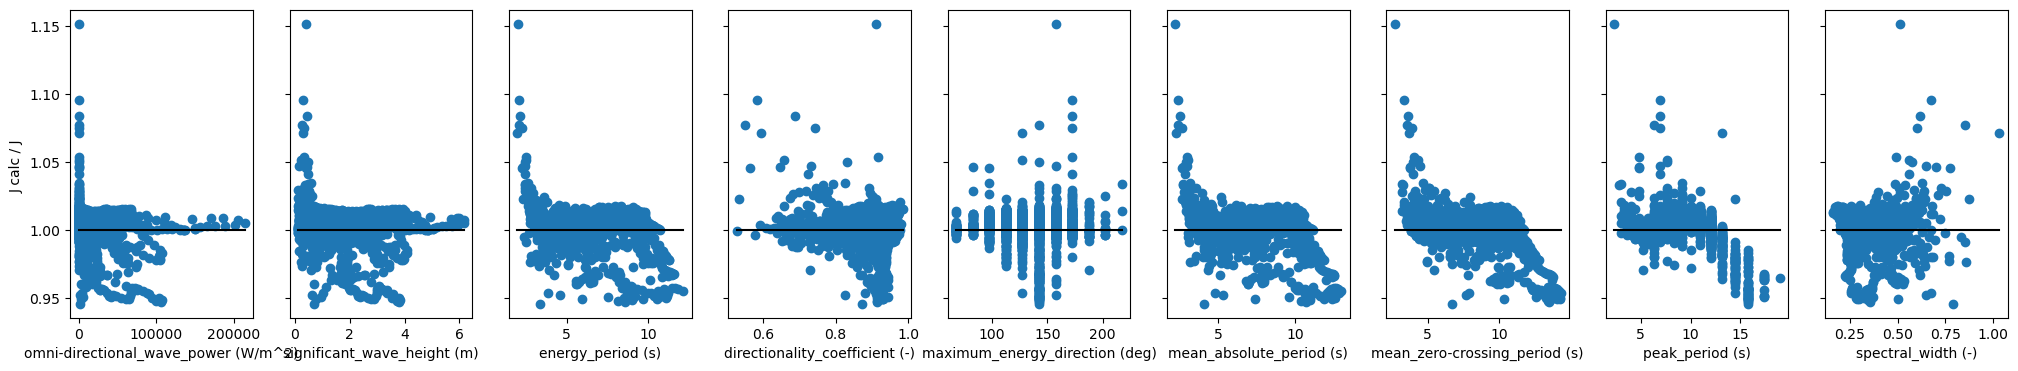

In [92]:
fig, ax = plt.subplots(1, parameters.__len__(), sharey=True, figsize=(25, 4))
units = ["W/m^2", "m", "s", "-", "deg", "s", "s", "s", "-"]
for i in range(parameters.__len__()):
    col = parameters[i] + "_0"
    if False: #"period" in col and col != "energy_period_0":
        normalize = True
        norm = data_mod["energy_period_0"]
    else:
        norm = 1
        normalize = False
    x_data = data_mod[col] / norm
    ax[i].scatter(x_data, 1/data_mod["ratio_power_density"])
    label = parameters[i] + " (" + units[i] + ")"
    if normalize:
        label += " / " + "energy_period" + " (s)"
    ax[i].set_xlabel(label)
    ax[i].plot([x_data.min(), x_data.max()], [1, 1], color='k')
ax[0].set_ylabel("J calc / J ")

In [93]:
data_mod["Avail"] = data["omni-directional_wave_power_0"] / np.max(data["omni-directional_wave_power_0"]) 
P_lim_list = np.concatenate( (np.linspace(0.005, 0.025, num=5), np.linspace(0.03, 0.09, num=7), np.linspace(0.1,0.9,num=9)) )

for P_limit in P_lim_list:
    key = "Avail_limited_"+str(int(P_limit*1000))
    data_mod[key] = np.minimum(data_mod["Avail"], P_limit) / P_limit

means = data_mod.mean()
CFs = np.array(means)[1:]
print(means)
CFs = np.concatenate([CFs[1:],CFs[:1]])
print(CFs)

omni-directional_wave_power_0    10861.985352
significant_wave_height_0            1.255046
energy_period_0                      5.798270
directionality_coefficient_0         0.894608
maximum_energy_direction_0         138.585617
mean_absolute_period_0               6.459770
mean_zero-crossing_period_0          7.465244
peak_period_0                        8.898335
spectral_width_0                     0.327541
Power_density_predicted          10847.621094
ratio_power_density                  0.997325
Avail                                0.050703
Avail_limited_5                      0.903712
Avail_limited_10                     0.810355
Avail_limited_15                     0.726794
Avail_limited_20                     0.660518
Avail_limited_25                     0.607014
Avail_limited_30                     0.563229
Avail_limited_40                     0.497209
Avail_limited_50                     0.448408
Avail_limited_60                     0.411962
Avail_limited_70                  

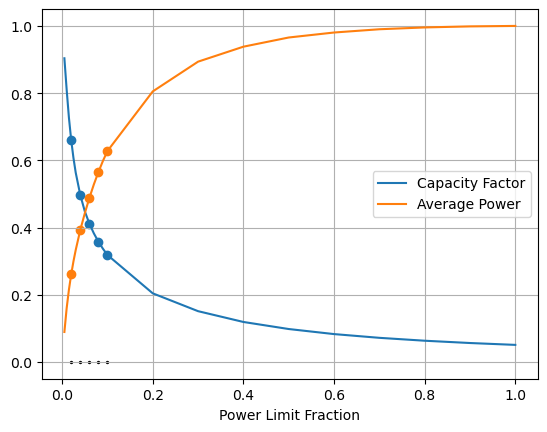

In [5]:

fig, ax = plt.subplots()
P_lim_frac = np.concatenate((P_lim_list,[1]))
ax.plot(P_lim_frac, CFs, label='Capacity Factor')
idx = np.searchsorted(P_lim_frac, [0.02,0.04,0.06,0.08,0.10], sorter=np.argsort(P_lim_frac))
ax.scatter(P_lim_frac[idx],CFs[idx])

P_avg = np.multiply(P_lim_frac,CFs) / CFs[-1]
ax.plot(P_lim_frac,  P_avg, label='Average Power')
ax.scatter(P_lim_frac[idx],P_avg[idx])

ax.scatter(P_lim_frac[idx],0*P_lim_frac[idx], s=2, color='k')

ax.set(xlabel='Power Limit Fraction')
ax.legend(loc='center right')
ax.grid()
plt.show()

(0.0, 0.12)

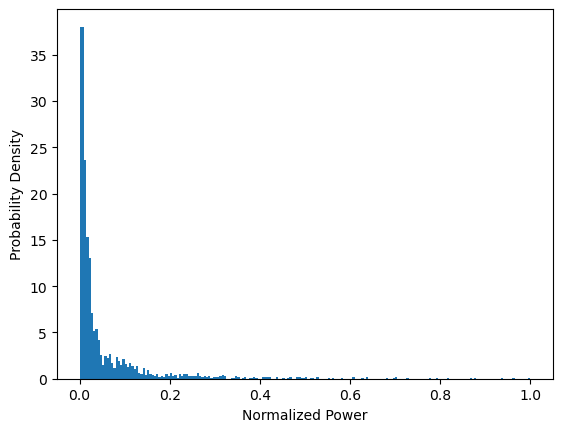

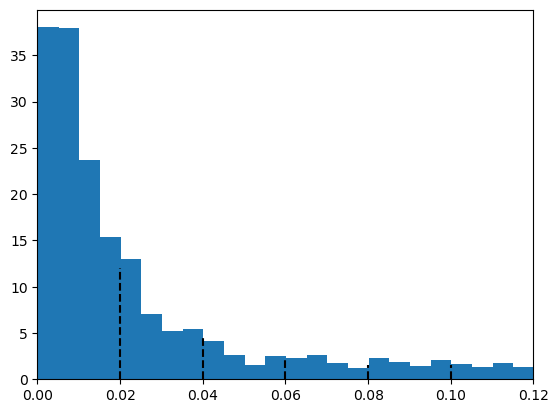

In [6]:
fig, ax = plt.subplots()
plt.hist(data_mod.Avail, bins=200, density=True)
plt.xlabel('Normalized Power')
plt.ylabel('Probability Density')

fig, ax = plt.subplots()
plt.hist(data_mod.Avail, bins=200, density=True)
plt.plot([0.02, 0.02],[0,12],'k--', [0.04,0.04],[0,4.5],'k--', [0.06,0.06],[0,2.2],'k--',
          [0.08,0.08],[0,1.5],'k--', [0.1,0.1],[0,1.5],'k--')
plt.xlim([0,0.12])

In [7]:
cap_costs = np.linspace(10000, 300000, 5)
P_lims = np.array([0.02, 0.04, .06, .08, 0.1])

cap_cost_mesh, P_lim_mesh = np.meshgrid(cap_costs, P_lims)
cap_cost_vec = cap_cost_mesh.flatten()
P_lim_vec = P_lim_mesh.flatten()

print(cap_cost_vec)
print(P_lim_vec)

P_lim_string = (P_lim_vec*1000).astype(int).astype(str)
keys = np.char.add( np.repeat("Avail_limited_",np.size(P_lim_vec)), P_lim_string )
print(keys)

# use CF to lookup power limit and corresponding availability timeseries

[ 10000.  82500. 155000. 227500. 300000.  10000.  82500. 155000. 227500.
 300000.  10000.  82500. 155000. 227500. 300000.  10000.  82500. 155000.
 227500. 300000.  10000.  82500. 155000. 227500. 300000.]
[0.02 0.02 0.02 0.02 0.02 0.04 0.04 0.04 0.04 0.04 0.06 0.06 0.06 0.06
 0.06 0.08 0.08 0.08 0.08 0.08 0.1  0.1  0.1  0.1  0.1 ]
['Avail_limited_20' 'Avail_limited_20' 'Avail_limited_20'
 'Avail_limited_20' 'Avail_limited_20' 'Avail_limited_40'
 'Avail_limited_40' 'Avail_limited_40' 'Avail_limited_40'
 'Avail_limited_40' 'Avail_limited_60' 'Avail_limited_60'
 'Avail_limited_60' 'Avail_limited_60' 'Avail_limited_60'
 'Avail_limited_80' 'Avail_limited_80' 'Avail_limited_80'
 'Avail_limited_80' 'Avail_limited_80' 'Avail_limited_100'
 'Avail_limited_100' 'Avail_limited_100' 'Avail_limited_100'
 'Avail_limited_100']


In [9]:
# make csv
csv_data = pd.DataFrame()
csv_data["Case"] = np.arange(1,P_lim_vec.size+1)
csv_data["waveInvCost"] = cap_cost_vec
csv_data["waveOMcost"] = cap_cost_vec / 10
csv_data["waveRegion"] = np.repeat("NENGREST",P_lim_vec.size)
csv_data["Notes"] = P_lim_vec
for hour in np.arange(1,8761):
    idx = hour - 1
    key = "waveAvail" + str(hour)
    row = data_mod.iloc[idx]
    csv_data[key] = row[keys].values
csv_data.head()


/tmp/ipykernel_1997299/467661109.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  csv_data[key] = row[keys].values
/tmp/ipykernel_1997299/467661109.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  csv_data[key] = row[keys].values
/tmp/ipykernel_1997299/467661109.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

IndexError: single positional indexer is out-of-bounds

In [ ]:
csv_data.to_csv('replacements.csv',index=False)

using Pkg
Pkg.activate("GenX")
]
include("caserunner.jl")